> 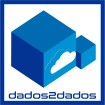


# Desafio de Dados: Consumindo API de Aluguel de Bicicleta
https://colab.research.google.com/gist/ricosuhete/4672c186a61857523ff94286e6f58bed/api_openweathermap.ipynb#scrollTo=kT1ExmSTC0I3
# RESOLUÇÃO:


Obter a lista de todas as estações de bicicletas e armazená-las em uma tabela SQL.

In [144]:
from pyspark.sql import SparkSession
import pandas as pd
import requests

url = "https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_information.json"
response = requests.get(url)

if response.status_code == 200:
    data1 = response.json()["data"]["stations"]
    
    # Inicie uma sessão Spark
    spark = SparkSession.builder.appName("desafio").getOrCreate()

   
    # Converte a lista de dicionários em um DataFrame do PySpark
    df_info_station = spark.createDataFrame(pd.DataFrame(data1))

    # Selecione apenas as colunas desejadas
    df_info_station = df_info_station.select("station_id", "name", "capacity")
    
    # Registrar o DataFrame como uma tabela temporária
    df_info_station.createOrReplaceTempView("stations_info")
    # Executar consulta SQL no DataFrame
    resultado2 = spark.sql("SELECT * FROM stations_info")   
    #resultado2.show()

else:
    print("Erro ao buscar os dados da URL.")

In [145]:
url = "https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_status.json"
response = requests.get(url)

if response.status_code == 200:
    data1 = response.json()["data"]["stations"]

    # Converte a lista de dicionários em um DataFrame do PySpark
    df_status = spark.createDataFrame(pd.DataFrame(data1))
    
    # Selecione apenas as colunas desejadas
    df_status = df_status.select("station_id", "num_bikes_available", "num_docks_available", "num_bikes_disabled")
    
    # Registrar o DataFrame como uma tabela temporária
    df_status.createOrReplaceTempView("stations_status")
    # Executar consulta SQL no DataFrame
    # resultado = spark.sql("SELECT * FROM stations_status WHERE num_bikes_available > 0")

    # Mostrar o resultado da consulta
    #resultado.show()
  
else:
    print("Erro ao buscar os dados da URL.")


Identificar a estação de bicicleta com a maior quantidade de bicicletas disponíveis em tempo real e exibir o resultado em uma tabela SQL.

In [146]:
resultado_join = spark.sql("""
SELECT
    stations_info.name,
    stations_status.num_bikes_available,
    stations_status.num_docks_available,
    stations_status.num_bikes_disabled    
FROM
    stations_info
LEFT JOIN
    stations_status ON stations_info.station_id = stations_status.station_id
WHERE 
    num_bikes_available > 0
ORDER BY num_bikes_available DESC LIMIT 1
""")

# resultado3 = spark.sql("SELECT name, capacity FROM stations_info ORDER BY capacity DESC LIMIT 1")
# resultado3.show()

# Mostrar o resultado da consulta
resultado_join.show()

                           

+----------------+-------------------+-------------------+------------------+
|            name|num_bikes_available|num_docks_available|num_bikes_disabled|
+----------------+-------------------+-------------------+------------------+
|W 43 St & 10 Ave|                 98|                  5|                 4|
+----------------+-------------------+-------------------+------------------+



Calcular a média de duração de uma viagem em cada estação de bicicleta e exibir os resultados em uma tabela SQL.

In [147]:
# Ler o arquivo CSV com cabeçalho
df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Selecione as colunas desejadas
df_time = df_time.select("start_station_name", "end_station_name", "started_at", "ended_at")

# Registrar o DataFrame como uma tabela temporária
df_time.createOrReplaceTempView("tripdata")

# Executar consulta SQL no DataFrame
resultado = spark.sql("""SELECT
    start_station_name,
    FROM_UNIXTIME(AVG(UNIX_TIMESTAMP(ended_at) - UNIX_TIMESTAMP(started_at)), 'HH:mm:ss') AS average_duration
FROM tripdata
GROUP BY start_station_name
                    """)
resultado.show()


+--------------------+----------------+
|  start_station_name|average_duration|
+--------------------+----------------+
|Nassau St & Duffi...|        00:14:07|
|Buchanan Pl & Gra...|        00:13:56|
|     E 63 St & 3 Ave|        00:18:25|
|       19 St & 8 Ave|        00:12:31|
|       45 Rd & 11 St|        00:14:33|
| Sterling Pl & 5 Ave|        00:14:24|
|  N 11 St & Kent Ave|        00:13:38|
|E Tremont Ave & E...|        00:20:06|
|College Ave & E 1...|        00:15:12|
|E 141 St & Jackso...|        00:13:43|
|       5 Ave & 66 St|        00:19:09|
|     31 Ave & 103 St|        00:17:12|
|   Dean St & Hoyt St|        00:13:57|
|     W 20 St & 5 Ave|        00:14:25|
| Park Ave & E 124 St|        00:14:25|
|Popham Ave & W 17...|        00:16:41|
| 20 Ave & Shore Blvd|        00:17:01|
|Van Buren St & Br...|        00:14:35|
| Berkeley Pl & 6 Ave|        00:14:29|
|Grand Concourse &...|        00:14:44|
+--------------------+----------------+
only showing top 20 rows



Determinar a hora do dia com a maior e a menor quantidade de viagens e exibir os resultados em uma tabela SQL.

In [148]:
# Ler o arquivo CSV com cabeçalho
df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Selecione as colunas desejadas
df_time = df_time.select("start_station_name", "end_station_name", "started_at", "ended_at")

# Registrar o DataFrame como uma tabela temporária
df_time.createOrReplaceTempView("tripdata")

# Consulta para a hora do dia com a maior quantidade de viagens
query_most_trips = """
SELECT
    DATE_FORMAT(CAST(trip_time AS TIMESTAMP), 'HH:00:00') AS hour,
    COUNT(*) AS trip_count
FROM (
    SELECT started_at AS trip_time FROM tripdata
    UNION ALL
    SELECT ended_at AS trip_time FROM tripdata
) AS trip_hours
GROUP BY hour
ORDER BY trip_count DESC
LIMIT 1
"""

# Consulta para a hora do dia com a menor quantidade de viagens
query_least_trips = """
SELECT
    DATE_FORMAT(CAST(trip_time AS TIMESTAMP), 'HH:00:00') AS hour,
    COUNT(*) AS trip_count
FROM (
    SELECT started_at AS trip_time FROM tripdata
    UNION ALL
    SELECT ended_at AS trip_time FROM tripdata
) AS trip_hours
GROUP BY hour
ORDER BY trip_count ASC
LIMIT 1
"""

# Executar a consulta para a hora do dia com a maior quantidade de viagens
resultado_most_trips = spark.sql(query_most_trips)

# Executar a consulta para a hora do dia com a menor quantidade de viagens
resultado_least_trips = spark.sql(query_least_trips)

# Exibir os resultados
resultado_most_trips.show()
resultado_least_trips.show()


+--------+----------+
|    hour|trip_count|
+--------+----------+
|18:00:00|    625225|
+--------+----------+

+--------+----------+
|    hour|trip_count|
+--------+----------+
|04:00:00|     25949|
+--------+----------+



Calcular a média de duração de uma viagem em cada hora do dia e exibir os resultados em uma tabela SQL.

In [149]:
# Ler o arquivo CSV com cabeçalho
df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Selecione as colunas desejadas
df_time = df_time.select("started_at", "ended_at")

# Registrar o DataFrame como uma tabela temporária
df_time.createOrReplaceTempView("tripdata")

# Consulta para calcular a média de duração de viagem em cada hora do dia
query_avg_duration = """
SELECT
    DATE_FORMAT(CAST(started_at AS TIMESTAMP), 'HH') AS hour,
    FROM_UNIXTIME(AVG(unix_timestamp(ended_at) - unix_timestamp(started_at)), 'HH:mm:ss') AS average_duration
FROM tripdata
GROUP BY hour
ORDER BY hour
"""

# Executar a consulta
resultado_avg_duration = spark.sql(query_avg_duration)

# Exibir os resultados
resultado_avg_duration.show(24)



+----+----------------+
|hour|average_duration|
+----+----------------+
|  00|        00:17:06|
|  01|        00:17:35|
|  02|        00:17:56|
|  03|        00:19:35|
|  04|        00:17:30|
|  05|        00:13:35|
|  06|        00:13:41|
|  07|        00:14:24|
|  08|        00:14:36|
|  09|        00:14:38|
|  10|        00:16:00|
|  11|        00:16:41|
|  12|        00:16:51|
|  13|        00:16:55|
|  14|        00:16:49|
|  15|        00:16:35|
|  16|        00:16:25|
|  17|        00:15:56|
|  18|        00:15:40|
|  19|        00:15:22|
|  20|        00:15:14|
|  21|        00:15:19|
|  22|        00:16:17|
|  23|        00:16:28|
+----+----------------+



Identificar a estação de bicicleta mais popular com base no número total de viagens iniciadas e exibir o resultado em uma tabela SQL.

In [150]:
# Ler o arquivo CSV com cabeçalho
df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Selecione as colunas desejadas
df_time = df_time.select("start_station_name", "end_station_name", "started_at", "ended_at")

# Registrar o DataFrame como uma tabela temporária
df_time.createOrReplaceTempView("tripdata")

# Consulta para identificar a estação de bicicleta mais popular
query_most_popular_station = """
SELECT
    start_station_name,
    COUNT(*) AS total_trips
FROM tripdata
GROUP BY start_station_name
ORDER BY total_trips DESC
LIMIT 1
"""

# Executar a consulta
resultado_most_popular_station = spark.sql(query_most_popular_station)

# Exibir o resultado
resultado_most_popular_station.show()

+------------------+-----------+
|start_station_name|total_trips|
+------------------+-----------+
|   W 21 St & 6 Ave|      13596|
+------------------+-----------+



Obter o histórico de viagens de uma estação de bicicleta específica e exibir os resultados em uma tabela SQL.

In [151]:
# Ler o arquivo CSV com cabeçalho
df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Selecione as colunas desejadas
df_time = df_time.select("start_station_name", "ride_id","rideable_type", "started_at", "ended_at", "end_station_name")

# Registrar o DataFrame como uma tabela temporária
df_time.createOrReplaceTempView("tripdata")

# Executar consulta SQL no DataFrame
resultado = spark.sql("""SELECT * FROM tripdata WHERE start_station_name = 'E 63 St & 3 Ave'""")
resultado.show()

+------------------+----------------+-------------+-------------------+-------------------+--------------------+
|start_station_name|         ride_id|rideable_type|         started_at|           ended_at|    end_station_name|
+------------------+----------------+-------------+-------------------+-------------------+--------------------+
|   E 63 St & 3 Ave|4DDE4DD4298319E7| classic_bike|2023-09-27 07:24:49|2023-09-27 07:29:09|     5 Ave & E 63 St|
|   E 63 St & 3 Ave|E811BC6C7D4C8F02| classic_bike|2023-09-27 11:10:33|2023-09-27 11:16:19|     E 85 St & 3 Ave|
|   E 63 St & 3 Ave|6E0BACC997562445| classic_bike|2023-09-30 14:34:56|2023-09-30 14:55:13|W 87 St & West En...|
|   E 63 St & 3 Ave|2F3E8F74133D9EFB| classic_bike|2023-09-13 17:09:43|2023-09-13 17:30:09| Henry St & Grand St|
|   E 63 St & 3 Ave|0475B22A28BFFB04| classic_bike|2023-09-18 16:11:36|2023-09-18 16:43:31|W 84 St & Columbu...|
|   E 63 St & 3 Ave|8D6CBFAF03FF375A| classic_bike|2023-09-06 20:10:58|2023-09-06 20:17:28|     

Identificar a estação de bicicleta mais popular com base no número total de viagens iniciadas e exibir o resultado em uma tabela SQL.

In [152]:
# Ler o arquivo CSV com cabeçalho
df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Selecione as colunas desejadas
df_time = df_time.select("start_station_name", "ride_id","rideable_type", "started_at", "ended_at", "end_station_name")

# Registrar o DataFrame como uma tabela temporária
df_time.createOrReplaceTempView("tripdata")

consulta_sql = """
SELECT start_station_name, COUNT(*) as total_trips
FROM tripdata
GROUP BY start_station_name
ORDER BY total_trips DESC
LIMIT 1
"""

resultado = spark.sql(consulta_sql)
resultado.show()

+------------------+-----------+
|start_station_name|total_trips|
+------------------+-----------+
|   W 21 St & 6 Ave|      13596|
+------------------+-----------+



Calcular a média de distância percorrida em uma viagem e exibir o resultado em uma tabela SQL.

In [153]:
from pyspark.sql.functions import radians, atan2, sin, cos, lit, sqrt
# Ler o arquivo CSV com cabeçalho
df = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Registrar o DataFrame como uma tabela temporária
df.createOrReplaceTempView("tripdata")

df = df.withColumn("start_lat_rad", radians(df["start_lat"]))
df = df.withColumn("end_lat_rad", radians(df["end_lat"]))
df = df.withColumn("lat_diff_rad", radians(df["end_lat"] - df["start_lat"]))
df = df.withColumn("lng_diff_rad", radians(df["end_lng"] - df["start_lng"]))

df = df.withColumn(
    "a",
    sin(df["lat_diff_rad"] / 2) ** 2 + cos(df["start_lat_rad"]) * cos(df["end_lat_rad"]) * sin(df["lng_diff_rad"] / 2) ** 2
)

df = df.withColumn("c", 2 * atan2(sqrt(df["a"]), sqrt(1 - df["a"])))

# Raio da Terra em metros (aproximadamente)
earth_radius = 6371000
df = df.withColumn("distance", earth_radius * df["c"])

average_distance = df.selectExpr("round(AVG(distance), 2) as avg_distance").collect()[0]["avg_distance"]
df_result = spark.createDataFrame([(average_distance,)], ["distancia_media(m)"])

df_result.show()



+------------------+
|distancia_media(m)|
+------------------+
|           1945.57|
+------------------+



Determinar os dias da semana com a maior e a menor quantidade de viagens e exibir os resultados em uma tabela SQL.

In [154]:
# Ler o arquivo CSV com cabeçalho
df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)

# Selecione as colunas desejadas
df_time = df_time.select("start_station_name", "ride_id","rideable_type", "started_at", "ended_at", "end_station_name")

# Registrar o DataFrame como uma tabela temporária
df_time.createOrReplaceTempView("tripdata")

consulta_sql = """
SELECT 
    (SELECT date_format(started_at, 'EEEE') FROM tripdata GROUP BY date_format(started_at, 'EEEE') ORDER BY COUNT(*) DESC LIMIT 1) as dia_semana_mais_popular,
    (SELECT COUNT(*) FROM tripdata WHERE date_format(started_at, 'EEEE') = (SELECT date_format(started_at, 'EEEE') FROM tripdata GROUP BY date_format(started_at, 'EEEE') ORDER BY COUNT(*) DESC LIMIT 1)) as viagens_dia_mais_popular,
    (SELECT date_format(started_at, 'EEEE') FROM tripdata GROUP BY date_format(started_at, 'EEEE') ORDER BY COUNT(*) ASC LIMIT 1) as dia_semana_menos_popular,
    (SELECT COUNT(*) FROM tripdata WHERE date_format(started_at, 'EEEE') = (SELECT date_format(started_at, 'EEEE') FROM tripdata GROUP BY date_format(started_at, 'EEEE') ORDER BY COUNT(*) ASC LIMIT 1)) as viagens_dia_menos_popular
"""

resultado = spark.sql(consulta_sql)
resultado.show()




+-----------------------+------------------------+------------------------+-------------------------+
|dia_semana_mais_popular|viagens_dia_mais_popular|dia_semana_menos_popular|viagens_dia_menos_popular|
+-----------------------+------------------------+------------------------+-------------------------+
|                 Friday|                  609672|                  Monday|                   336507|
+-----------------------+------------------------+------------------------+-------------------------+



In [155]:
# Encerra a sessão Spark
print("Sessão spark encerrada")
spark.stop()

Sessão spark encerrada


In [156]:
# Executar consulta SQL no DataFrame
# df_time = spark.read.csv("/home/jovyan/work/desafiodabicicleta/202309-citibike-tripdata.csv", header=True)
# print(df_time.show())
#"ride_id","rideable_type", "started_at", "ended_at", "start_station_name", "end_station_name"

In [157]:
# import os
# print(os.path.abspath("202309-citibike-tripdata.csv"))